# word2vec을 활용한 적절한 문장 추천


이름: 홍수지

### 설명
#### 사진과 같이 사진 캡션을 여러 가지로 생성할 수도 있다. 이 경우에 어떤 설명이 가장 적절한 것인지 선택해야 할 필요성이 있다. 이 경우에 어떤 문장을 선택할지를 문장 유사도를 측정하고 이 중에서 가장 유사도가 높은 문장을 선택하면 될 수도 있다.

#### 이 과제에서는 다음 과정을 거쳐서 처리하고자 한다.

1. wmdistance를 적용해서 word2vec을 활용한 문장 유사도 측정
2. 2개씩 문장 유사도가 측정이 되므로 이를 적용해서 어떤 문장이 높은지 판단하는데, 문장과 문장의 측정이므로 A와 B의 관계로 두 개씩 짝지워진 행렬이다. 따라서 이를 활용해서 연결 행렬을 만들고
3. 이를 전체적으로 적용하면 pagerank 알고리즘을 적용한다.

#####사진 출처: https://vision.cs.uiuc.edu/pascal-sentences/


### 1. 사진과 사진 캡션 데이터 생성

In [18]:
from google.colab import drive

# Google Drive 마운트
drive.mount('/content/drive')
# 경로를 지정하여 이미지 표시
from IPython.display import Image
# 이미지 폴더 경로

image_folder = '/content/drive/MyDrive/텍스트마이닝/HW2_img'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
# 사진과 사진 캡션 데이터
img_captions = {
    "HW_img01.png": [
      "An Air Canada airplane flying in the sky.",
      "An airplane with a canadian symbols, flying.",
      "A small Air Canada jet coming in to land.",
      "The white airplane is flying in the blue sky.",
      "This passenger jet has its landing gear and flaps down in preparation for landing."
    ],
    "HW_img02.png": [
        "A little girl with a bike helmet posing by her bicycle.",
        "A smiling young blonde girl wearing a helmet sits in front of her bicycle.",
        "A young blonde girl wearing a helmet sits with a red bicycle behind her.",
        "A young blonde girl wearing a helmet with a bicycle in the background.",
        "A young girl wearing a bike helmet with a bicycle in the background."
    ]
}


 이미지: HW_img01.png


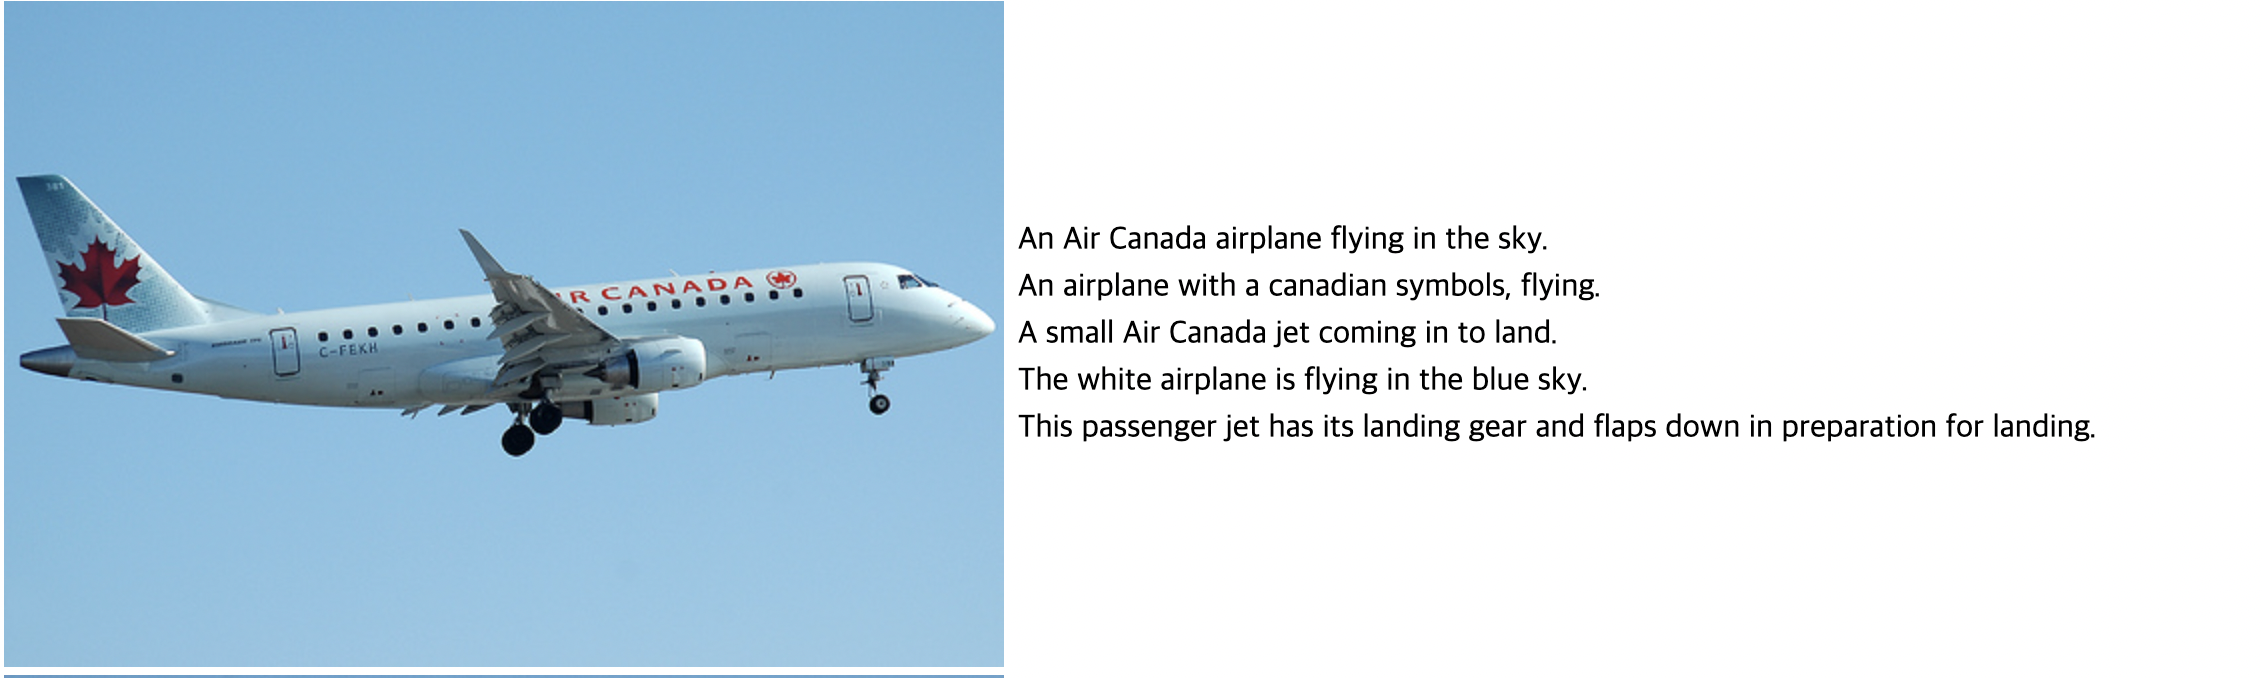


 이미지: HW_img02.png


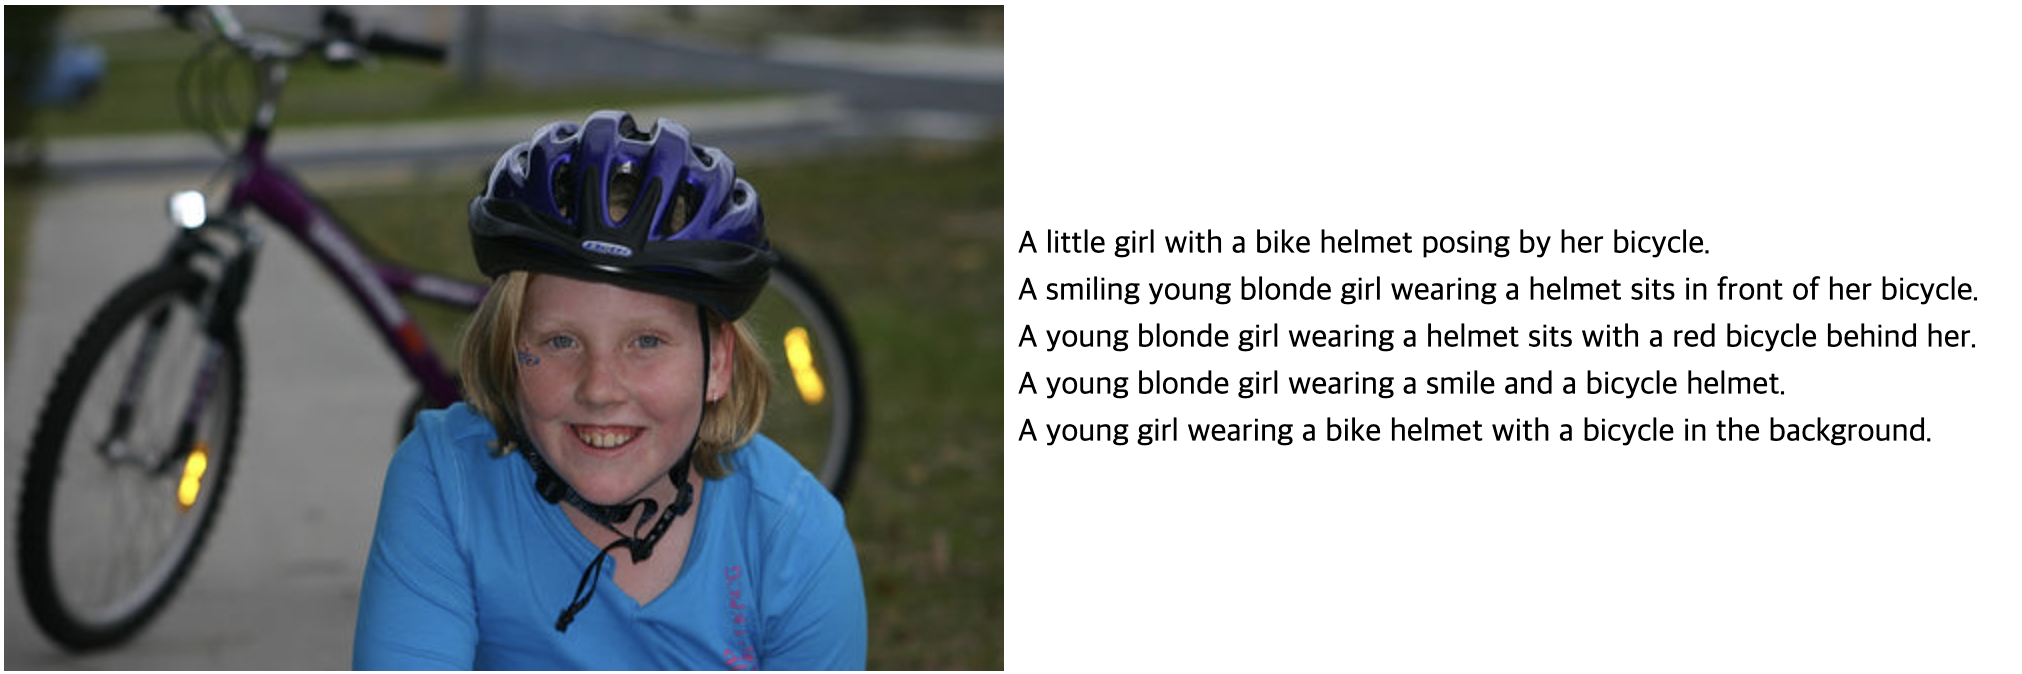

In [21]:
# 각 이미지별 처리
for img, captions in img_captions.items():
    print(f"\n 이미지: {img}")

    # 이미지 출력
    image_path = f"{image_folder}/{img}"
    display(Image(image_path))

### 2. 패키지 설치 및 불러오기

* **POT(Python Optimal Transport)**는 ot 모듈을 통해 Wasserstein 거리와 **Earth Mover's Distance(EMD)**와 같은 최적 수송 문제를 해결하기 위해 설치됩니다.

In [22]:
pip install pot

* numpy: 배열, 행렬 계산 및 수학적 연산을 수행하는 데 사용됩니다.
* math: 수학적 함수와 상수를 제공하여 계산을 지원합니다.
* gensim: Word2Vec 및 NLP 모델을 생성하거나 활용하여 텍스트 데이터를 벡터화하고 유사도를 계산합니다.
* ot: Optimal Transport(최적 수송) 문제를 해결하여 Wasserstein 거리 및 EMD 계산에 사용됩니다.

In [23]:
import numpy as np
import math
import gensim
import ot
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.keyedvectors import KeyedVectors

### 3. Word2Vec 모델 로드

Word2Vec 모델 종류 \
Word2Vec 모델을 로드하는 방법과 사용할 모델은 작업의 목적과 데이터의 특성에 따라 다릅니다
1. 일반적인 영어 데이터 작업: Google News Word2Vec (word2vec-google-news-300)이 가장 적합.
2. 빠른 실행 및 가벼운 모델: GloVe (glove-wiki-gigaword-300)이 적합.
3. 도메인 특화 작업: 도메인 데이터로 Word2Vec 직접 학습.
4. 문장 임베딩 또는 최신 모델: Sentence-BERT.

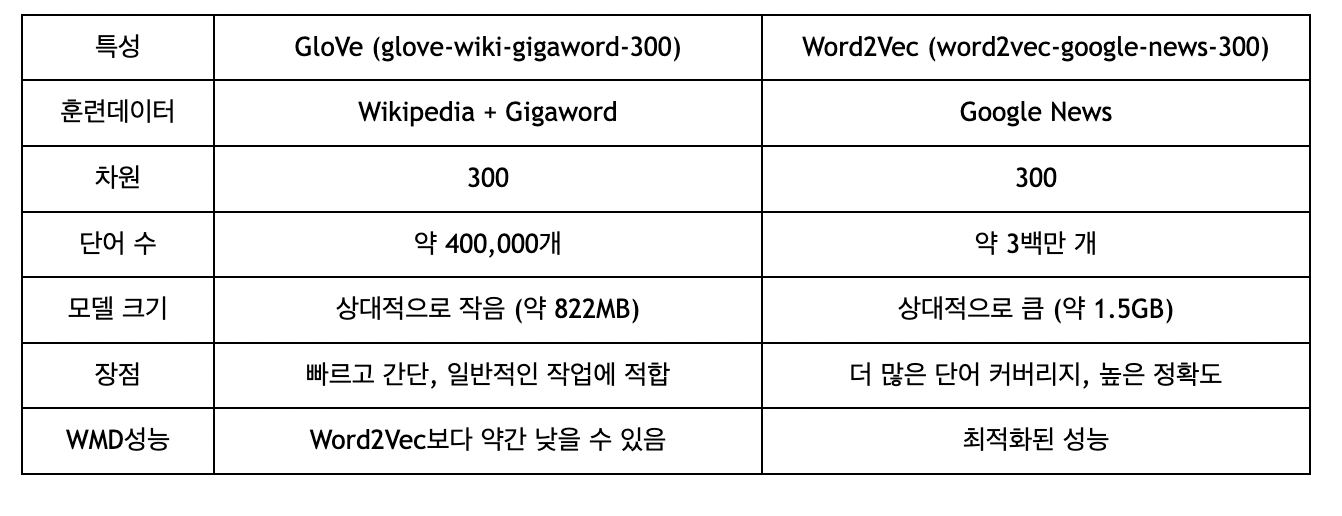

<font size="3" color="blue">Google News Word2Vec (word2vec-google-news-300)선택



In [27]:
# Gensim 내장된 Word2Vec 모델 로드 (GloVe (glove-wiki-gigaword-300)선택)
import gensim.downloader as api

# Gensim 내장 Word2Vec 모델 로드
w2v_model = api.load("word2vec-google-news-300")  # Google News Word2Vec 모델 로드

[==================================================] 100.0% 1662.8/1662.8MB downloaded


###4. WM Distance 메소드를 사용해서 문장의 유사도 측정

In [29]:
def calculate_similarity_matrix(captions, w2v_model):
    """
    문장 리스트를 기반으로 WMD를 계산하여 유사도 행렬 생성

    Args:
        captions (list): 문장 리스트
        w2v_model (KeyedVectors): 사전 학습된 Word2Vec 모델

    Returns:
        np.ndarray: 유사도 행렬 (n x n)
    """
    n = len(captions)
    similarity_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if i == j:
                similarity_matrix[i][j] = 1.0  # 자기 자신과의 유사도는 1.0
            else:
                # WMD 계산 및 유사도 변환
                wmd = w2v_model.wmdistance(captions[i], captions[j])
                similarity_matrix[i][j] = 1 / (1 + wmd)

    return similarity_matrix


### 5. Pagerank 알고리즘

PageRank 계산 과정
1. 유사도 행렬(Adjacency Matrix) 준비: WMD를 통해 계산된 유사도 행렬을 준비합니다.
2. 정규화: 유사도 행렬을 정규화하여 각 열의 합이 1이 되도록 변환합니다.
3. Damping Factor 적용: 무작위 이동 확률을 반영한 최종 행렬을 계산합니다.
4. Steady-State Vector 계산: PageRank 점수(정상 상태 벡터)를 계산합니다.

#### (1) normalizeAdjacencyMatrix
* 유사도 행렬(Adjacency Matrix)을 정규화하여 확률 행렬로 변환합니다.
* 각 열의 합이 1이 되도록 만듭니다.
* Dangling Node(모든 값이 0인 열)가 있을 경우, 열을 균등한 값으로 채웁니다.


In [37]:
# 행렬을 정규화 (확률 행렬로 변환, 모든 열의 합이 1이 되도록 만듦)
def normalizeAdjacencyMatrix(A):
    n = len(A)  # A의 행/열 크기
    for j in range(len(A[0])):
        sumOfCol = 0
        for i in range(len(A)):
            sumOfCol += A[i][j]  # 각 열의 합 계산

        if sumOfCol == 0:  # dangling node(값이 모두 0인 열) 처리
            for val in range(n):
                A[val][j] = 1/n  # 균등 분포로 설정
        else:
            for val in range(n):
                A[val][j] = (A[val][j] / sumOfCol)  # 열의 합으로 나눠 정규화
    return A


(2) dampingMatrix
* PageRank의 핵심 요소인 Damping Factor(보통 0.85)를 적용하여 사용자가 무작위로 다른 페이지로 이동할 확률을 반영합니다.
* 계산공식:
* 여기서:
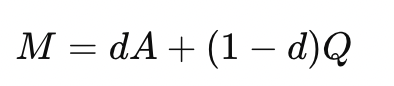
    * 𝐴:정규화된 유사도 행렬
    * 𝑄: 균등 확률 행렬
    * 𝑑:Damping Factor

In [36]:
# 공식을 사용하여 damping matrix(감쇠 행렬) 구현
# M = dA + (1-d)(1/n)Q, 여기서 Q는 모든 값이 1인 배열이며 d는 damping factor(감쇠 계수)이다
def dampingMatrix(A):
    n = len(A)  # A의 행/열 크기
    dampingFactor = 0.85  # 감쇠 계수 설정
    Q = [[1/n]*n]*n  # 모든 값이 1/n인 균등 확률 행렬 Q 생성
    arrA = np.array(A)
    arrQ = np.array(Q)
    arrM = np.add((dampingFactor)*arrA, (1-dampingFactor)*arrQ)  # 감쇠 행렬 생성
    return arrM


#### (3) findSteadyState
* 최종 행렬의 Steady-State Vector(정상 상태 벡터)를 계산합니다.
* 정상 상태 벡터는 고유값 1에 해당하는 고유 벡터로, PageRank 점수에 해당합니다.
* 벡터를 정규화하여 합이 1이 되도록 만듭니다.

In [ ]:
def findSteadyState(M, n):
    # 고유 벡터 계산
    evectors = np.linalg.eig(M)[1]

    # 고유 값 계산
    eigenValues = np.linalg.eig(M)[0]
    lstEVals = []
    for val in eigenValues:
        lstEVals.append(round(val))

    # 고유 값 1에 해당하는 고유 벡터 찾기
    idxWithEval1 = lstEVals.index(1)
    steadyStateVector = evectors[:, idxWithEval1]

    # 정상 상태 벡터를 정규화하여 구성 요소의 합이 1이 되도록 만듦
    lstVersionSteadyState = []
    sumOfComps = 0
    returnVector = []
    for val in steadyStateVector:
        sumOfComps += val
        lstVersionSteadyState.append(val)
    for val in lstVersionSteadyState:
        returnVector.append(val/sumOfComps)

    return returnVector


####(4) pageRank
* 위의 모든 과정을 통합하여 PageRank 점수를 계산하는 함수입니다.
* 유사도 행렬을 입력받아 PageRank 점수를 반환합니다.


In [34]:
def pageRank(A):
    n = len(A)
    A = normalizeAdjacencyMatrix(A)  # 정규화
    M = dampingMatrix(A)  # Damping Factor 적용
    # Steady-State Vector 계산
    steadyStateVectorOfA = findSteadyState(M, n)
    return steadyStateVectorOfA


### 6. 결과


Processing HW_img01.png...


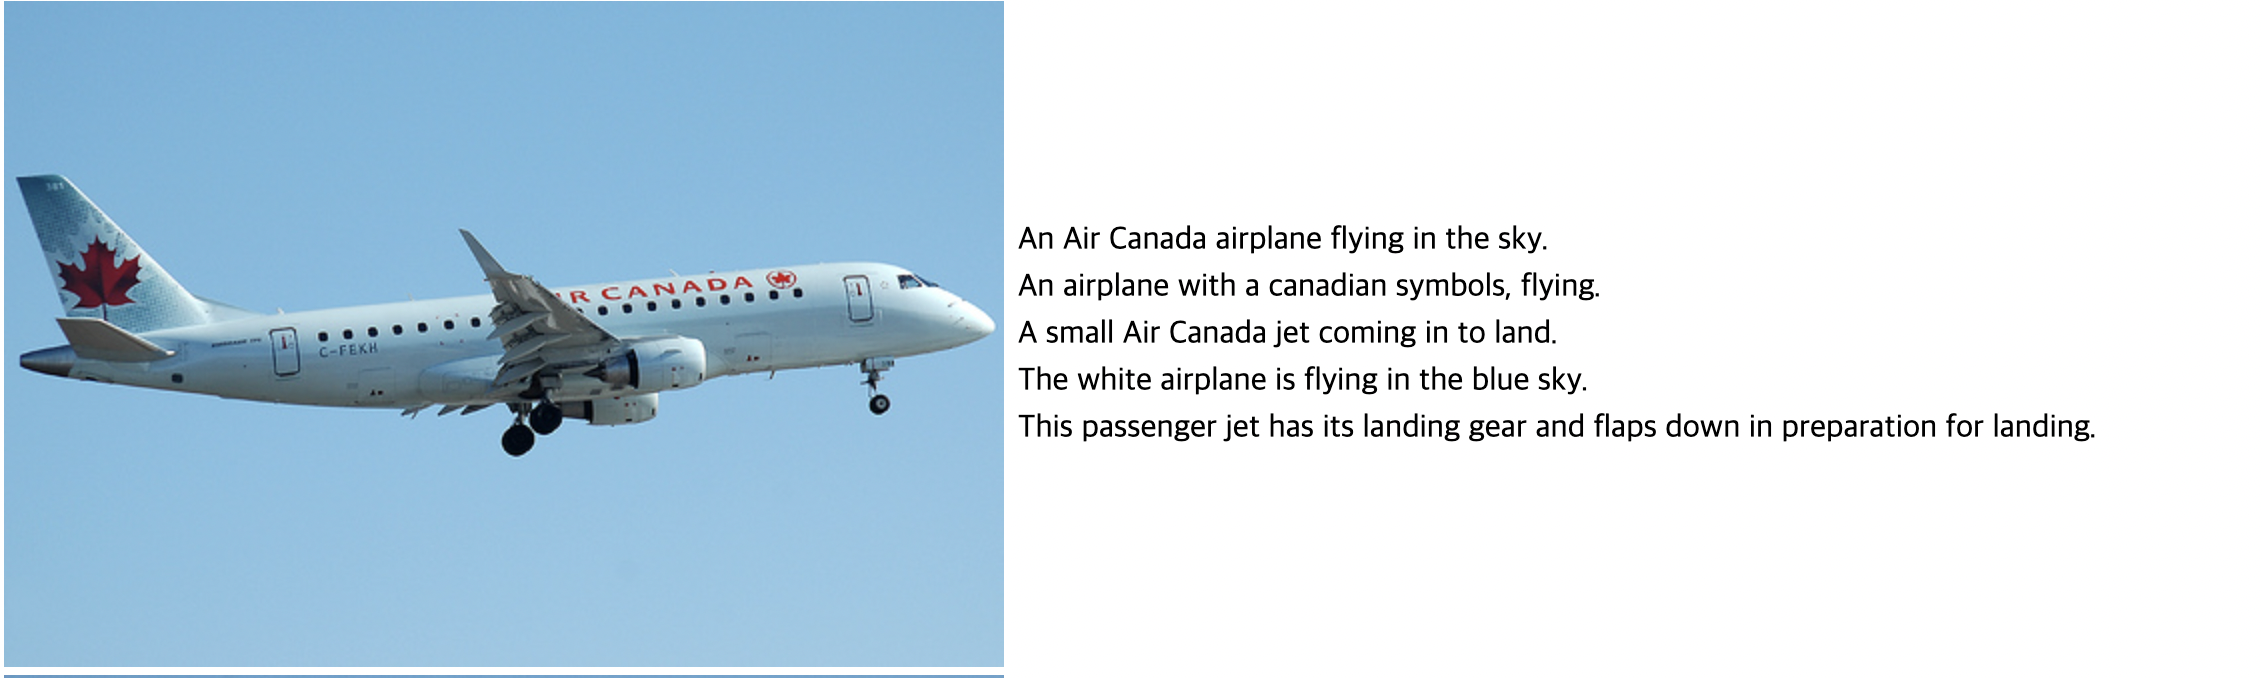


유사도 행렬:
[[1.         0.80062482 0.74667353 0.74825541 0.75222479]
 [0.80062482 1.         0.76489415 0.75197367 0.75601502]
 [0.74667353 0.76489415 1.         0.65240827 0.72047491]
 [0.74825541 0.75197367 0.65240827 1.         0.7236032 ]
 [0.75222479 0.75601502 0.72047491 0.7236032  1.        ]]

[HW_img01.png - 문장 중요도 순위]
An airplane with a canadian symbols, flying. (Score: 0.2045)
An Air Canada airplane flying in the sky. (Score: 0.2034)
This passenger jet has its landing gear and flaps down in preparation for landing. (Score: 0.1994)
A small Air Canada jet coming in to land. (Score: 0.1965)
The white airplane is flying in the blue sky. (Score: 0.1962)


Processing HW_img02.png...


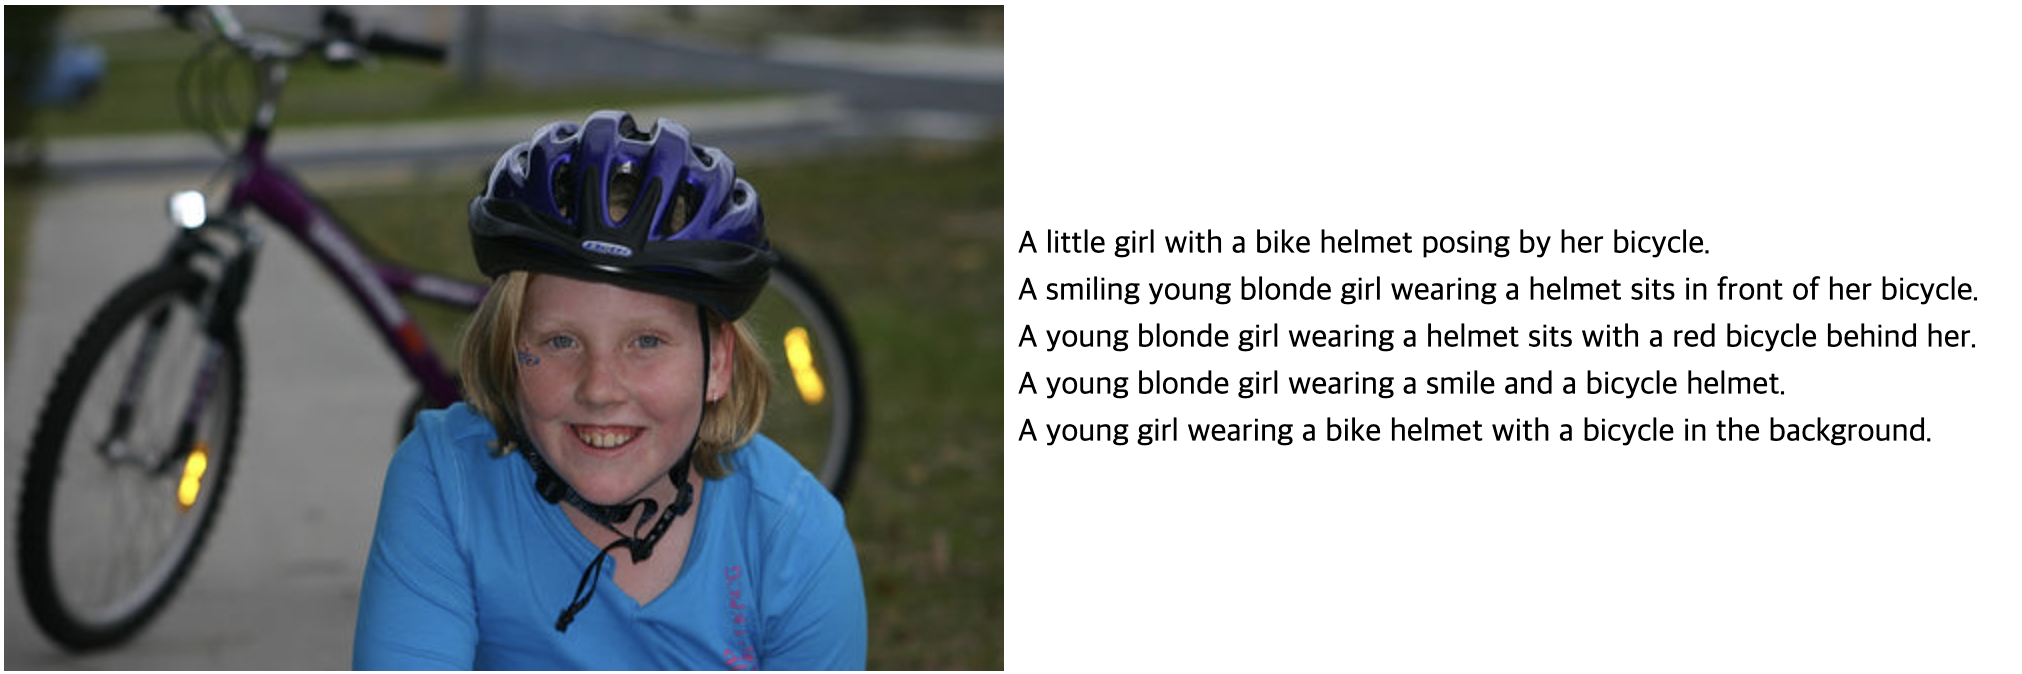


유사도 행렬:
[[1.         0.78586818 0.83245739 0.80815096 0.82434583]
 [0.78586818 1.         0.85734639 0.85378705 0.83501561]
 [0.83245739 0.85734639 1.         0.87816163 0.86970504]
 [0.80815096 0.85378705 0.87816163 1.         0.93129084]
 [0.82434583 0.83501561 0.86970504 0.93129084 1.        ]]

[HW_img02.png - 문장 중요도 순위]
A young blonde girl wearing a helmet with a bicycle in the background. (Score: 0.2031)
A young girl wearing a bike helmet with a bicycle in the background. (Score: 0.2027)
A young blonde girl wearing a helmet sits with a red bicycle behind her. (Score: 0.2018)
A smiling young blonde girl wearing a helmet sits in front of her bicycle. (Score: 0.1977)
A little girl with a bike helmet posing by her bicycle. (Score: 0.1946)



In [40]:
#  PageRank 계산 및 결과 출력
def process_captions(img_captions):
    """
    각 이미지에 대해 유사도 행렬을 생성하고 PageRank를 적용하여 중요 문장을 계산
    """
    results = {}
    for img, captions in img_captions.items():
        print(f"\nProcessing {img}...")
        image_path = f"{image_folder}/{img}"
        display(Image(image_path))

        # 유사도 행렬 생성
        similarity_matrix = calculate_similarity_matrix(captions, w2v_model)

        # 유사도 행렬 출력
        print("\n유사도 행렬:")
        print(similarity_matrix)

        # PageRank 계산
        ranks = pageRank(similarity_matrix)

        # 중요 문장 정렬
        ranked_sentences = sorted(((r, s) for r, s in zip(ranks, captions)), reverse=True)
        results[img] = ranked_sentences

        # 중요 문장 출력
        print(f"\n[{img} - 문장 중요도 순위]")
        for rank, sentence in ranked_sentences:
            print(f"{sentence} (Score: {rank:.4f})")
        print()

    return results

# 실행
results = process_captions(img_captions)